#**1) EXPLORATIVE DATA ANALYSIS**

---


In [ ]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns
import matplotlib.colors as mcolors

# Pre-processing
import spacy
from spacy.lang.it import Italian

In [ ]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt'
]

In [ ]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

In [ ]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [ ]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [ ]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


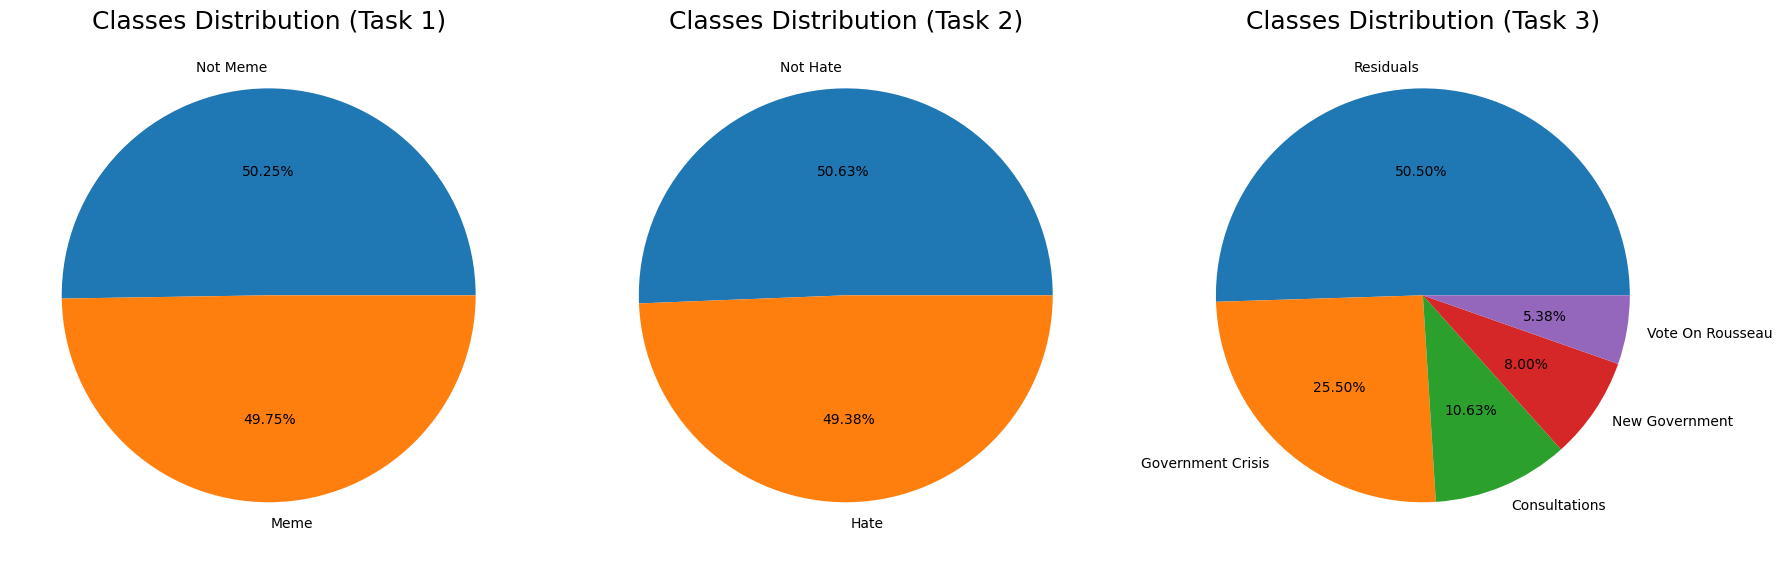

In [ ]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

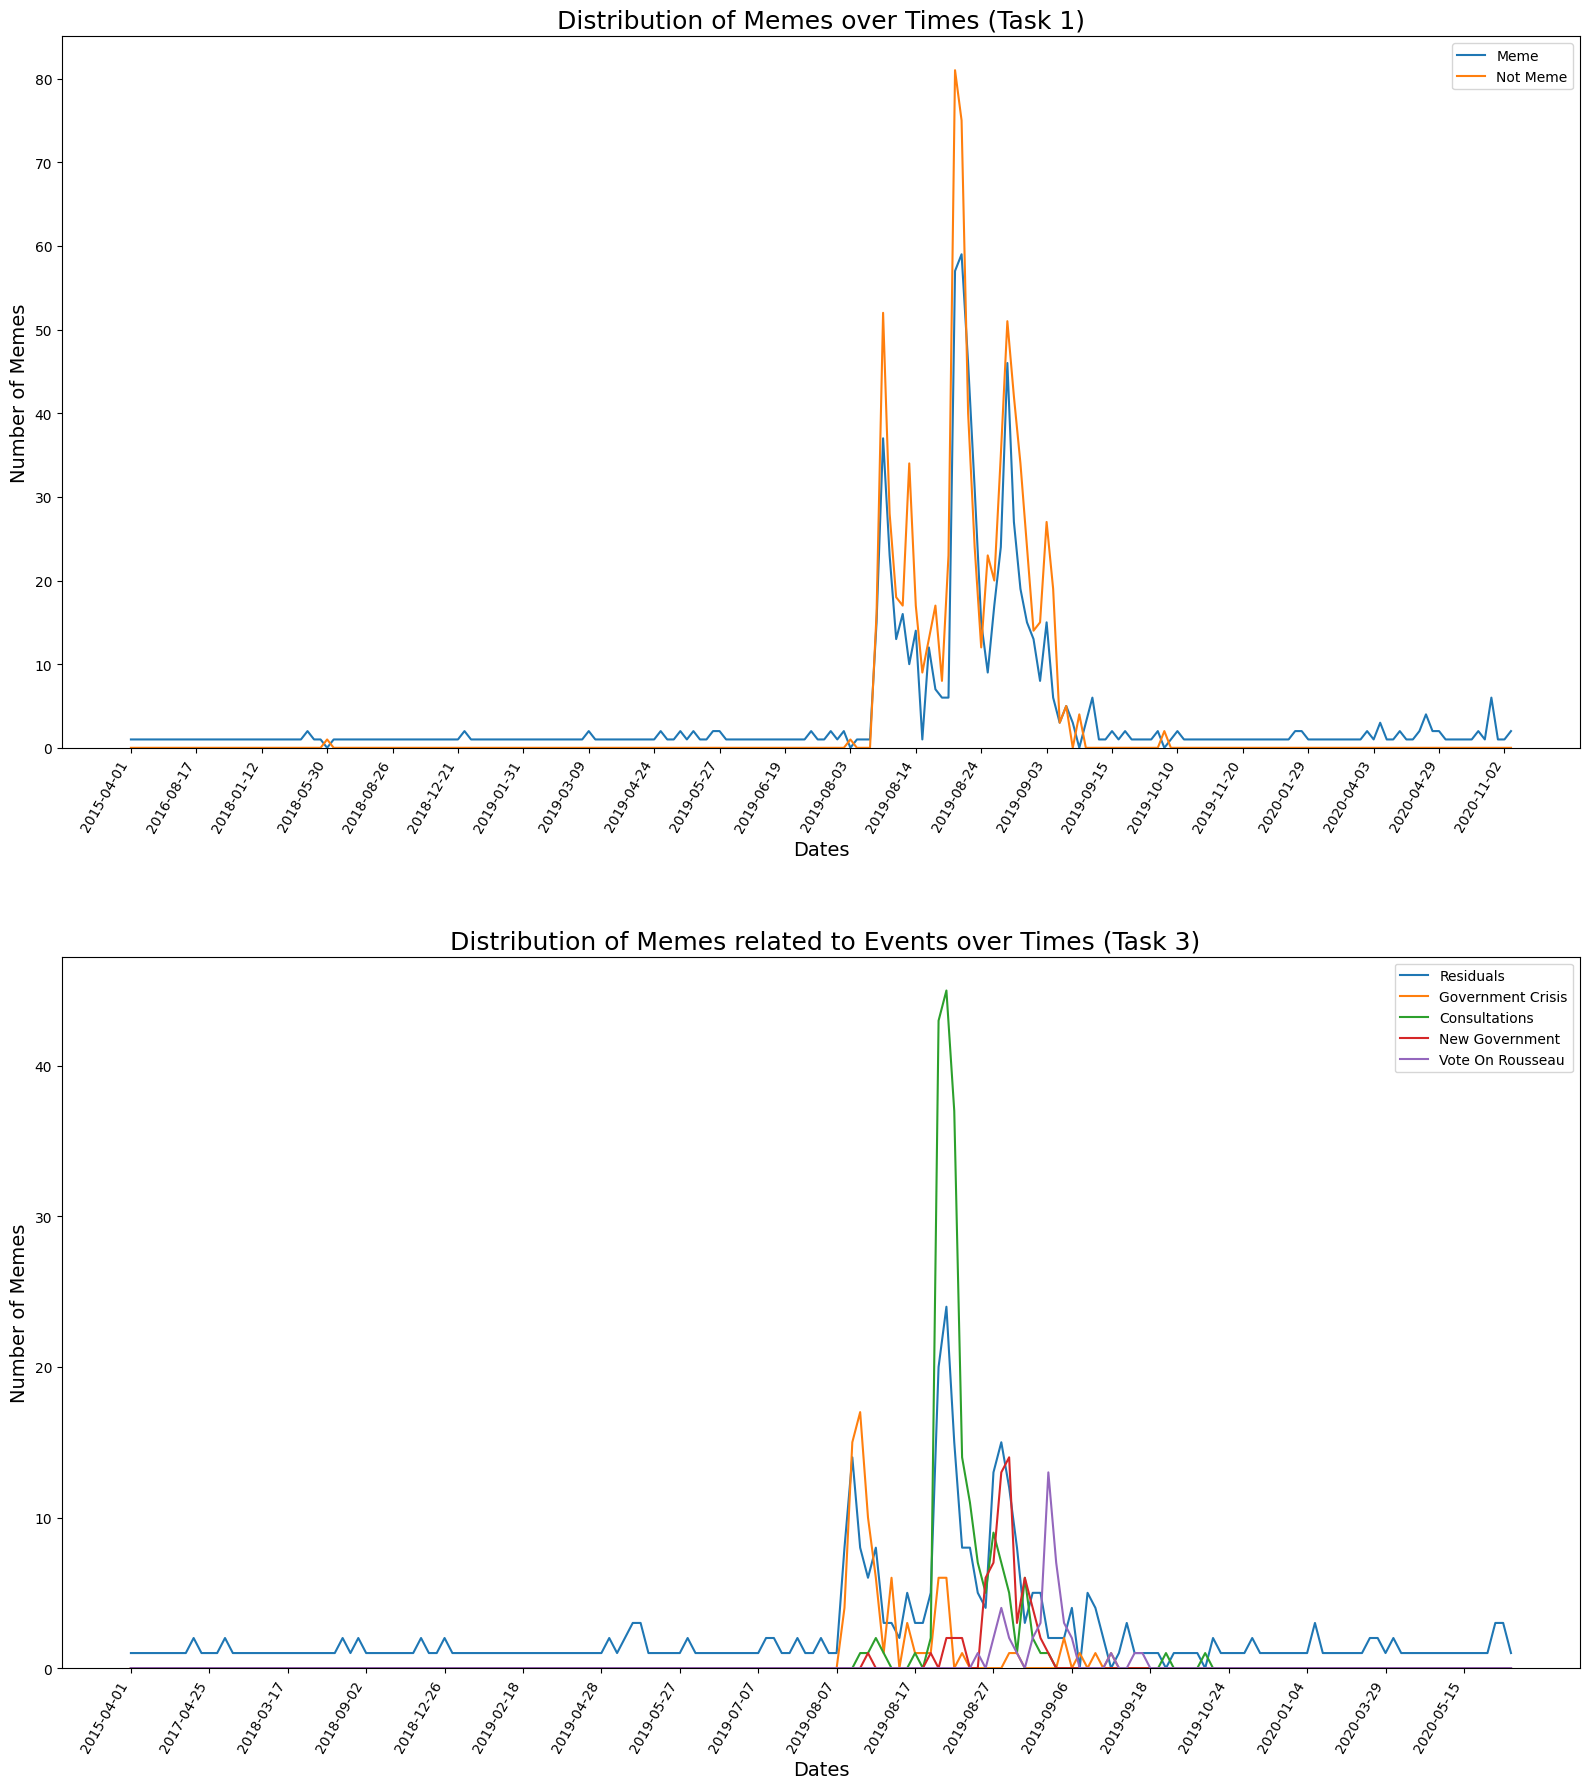

In [ ]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

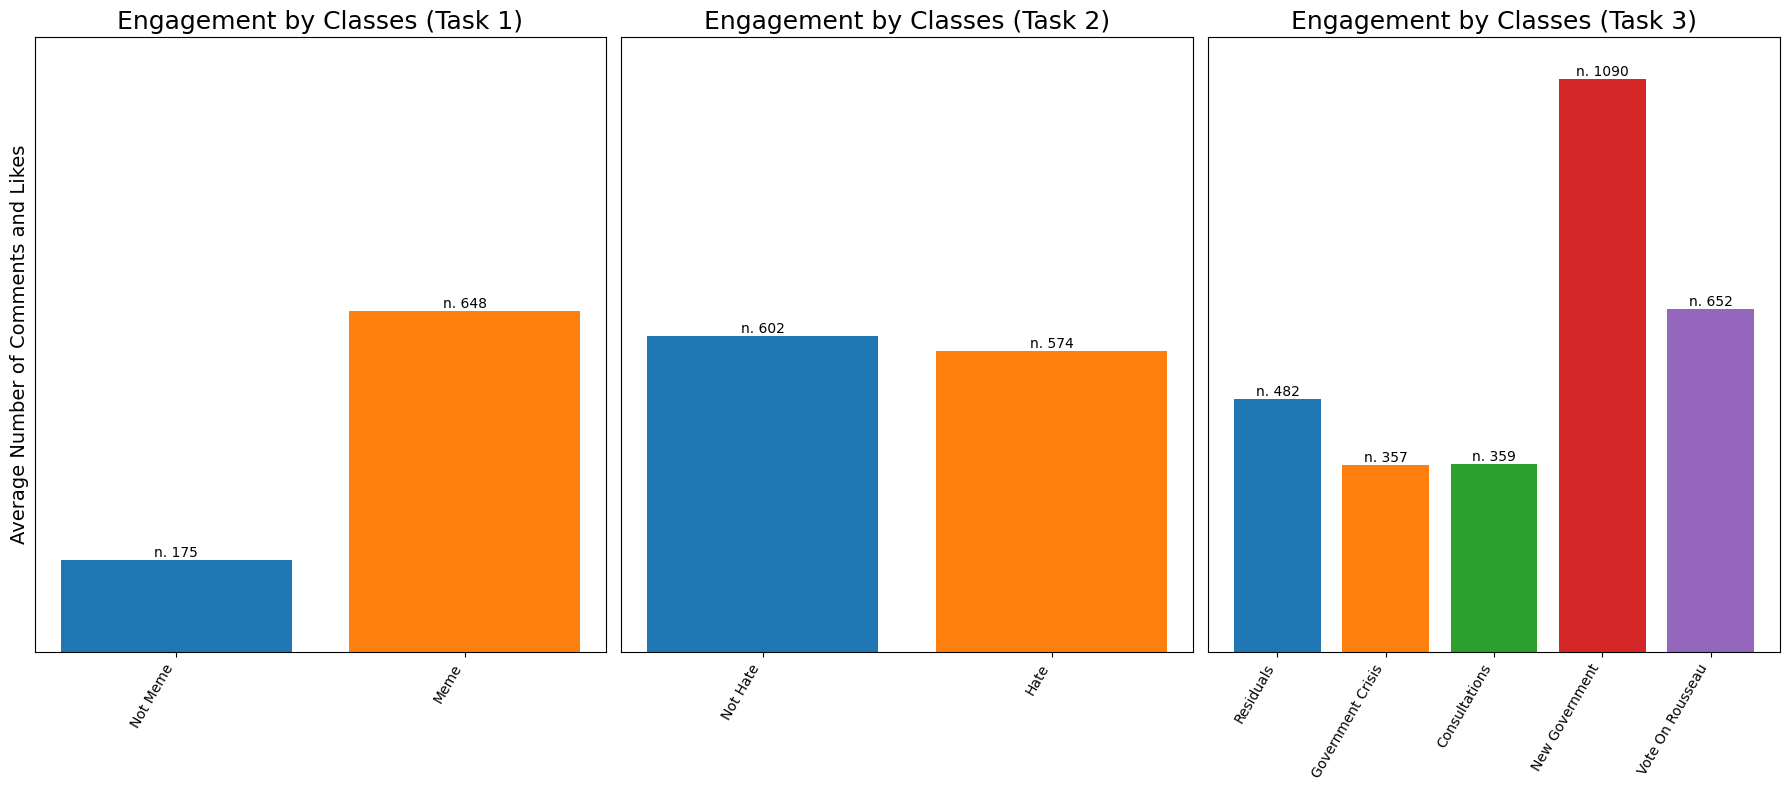

In [ ]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

#**2) PRE-PROCESSING**

---


In [ ]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = spacy.lang.it.stop_words.STOP_WORDS

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [ ]:
def get_explicit(censored):
    explicit = False
    start = censored.text.split('*')[0]
    end = censored.text.split('*')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is censored.tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check)
        else:
            explicit = random.choice(options)
    return explicit

In [ ]:
def my_preprocessing(sentence, hashtag=False, badwords=True, lemmatization=True):

    #1 Tokenization
    tokens = nlp(sentence)

    #2 Normalization
    if badwords:
        tokens_norm = []
        for t in tokens:
            if (not re.findall('[a-z]+\*+\w+', t.text)):
                tokens_norm.append(t)
            elif get_explicit(t):
                tokens_norm.append(get_explicit(t))
        tokens = tokens_norm
    
    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations ]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_ for w in nlp(' '.join(tokens))]

    return tokens

#**3) FEATURES EXTRACTION**

---


In [ ]:
visual1 = task_1_train['Visual']
visual2 = task_2_train['Visual']
visual3 = task_3_train['Visual']


df3 = pd.DataFrame(index=task_1_train.index, columns=['Visual','Visual Length'])
df3.loc[task_1_train.index, 'Visual'] = visual1.values
df3.loc[task_1_train.index, 'Visual Length'] = [len(visual1[i]) for i in range(len(visual1))]

df4 = pd.DataFrame(index=task_2_train.index, columns=['Visual','Visual Length'])
df4.loc[task_2_train.index, 'Visual'] = visual2.values
df4.loc[task_2_train.index, 'Visual Length'] = [len(visual2[i]) for i in range(len(visual2))]

df5 = pd.DataFrame(index=task_3_train.index, columns=['Visual','Visual Length'])
df5.loc[task_3_train.index, 'Visual'] = visual3.values
df5.loc[task_3_train.index, 'Visual Length'] = [len(visual3[i]) for i in range(len(visual3))]


print(visual1[pd.to_numeric(df3['Visual Length']).argmax()])
print(visual2[pd.to_numeric(df4['Visual Length']).argmax()])
print(visual3[pd.to_numeric(df5['Visual Length']).argmax()])

people1 = []
for i in visual1:
    s = i.split(', ')
    for e in s:
        if (e is not '0' and e.title() not in people1):
            people1.append(e.title())

people2 = []
for i in visual2:
    s = i.split(', ')
    for e in s:
        if (e is not '0' and e.title() not in people2):
            people2.append(e.title())

people3 = []
for i in visual3:
    s = i.split(', ')
    for e in s:
        if (e is not '0' and e.title() not in people3):
            people3.append(e.title())

print('\n')
print(len(people1))
print(people1)

print('\n')
print(len(people2))
print(people2)

print('\n')
print(len(people3))
print(people3)

Meloni, Rosy Bindi, Vendola, Santanchè, Gelmini, Renzi, Casini, Minetti, Giannino, Grillo, Merkel, Berlusconi
Meloni, Rosy Bindi, Vendola, Santanchè, Gelmini, Renzi, Casini, Minetti, Giannino, Grillo, Merkel, Berlusconi
Meloni, Rosy Bindi, Vendola, Santanchè, Gelmini, Renzi, Casini, Minetti, Giannino, Grillo, Merkel, Berlusconi


62
['Salvini', 'Di Maio', 'Grillo', 'Mattarella', 'Conte', 'Zingaretti', 'Meloni', 'Casaleggio', 'Toninelli', 'Giorgetti', 'Boschi', 'Cirinnà', 'Berlusconi', 'Renzi', 'Napolitano', 'Monti', 'Draghi', 'M5S', 'Casalino', 'Appendino', 'Civati', 'Pd', 'Lega', "Fratelli D'Italia", 'Forza Italia', 'Di Battista', 'Fico', 'Bellanova', "D'Uva", 'Mentana', 'Gentiloni', 'Delrio', 'Putin', 'Bossi', 'Belsito', 'Rosy Bindi', 'Vendola', 'Santanchè', 'Gelmini', 'Casini', 'Minetti', 'Giannino', 'Merkel', 'Adinolfi', "D'Alema", 'Prodi', 'Cuperlo', 'Fdi', 'Bussetti', 'De Magistris', 'Del Rio', 'Tria', 'Fornero', 'Mattarella,', 'Bonafede', 'Taverna', 'Letta', 'Berlusconi,', 'Giov

In [ ]:
data["N_words_text"] = data['Text'].apply(lambda x:len(str(x).split()))
data.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech,N_words_text
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1,15
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0,14
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1,17
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1,9
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0,26


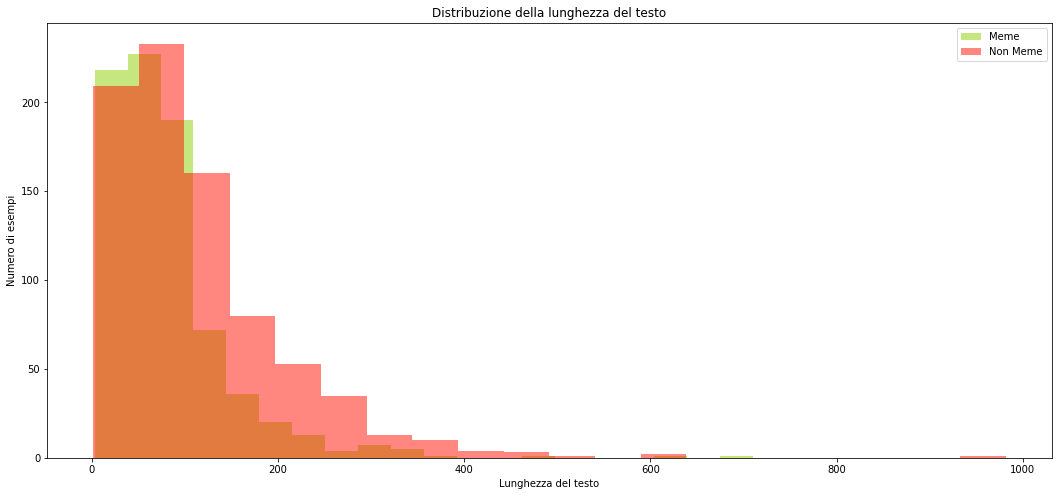

In [ ]:
# Visualizzo la lunghezza del testo dei meme e delle immagini che non sono meme
# Filtra il dataset per i valori con meme = 1
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]

# Calcola la lunghezza del testo per i valori con meme = 1
meme_dataset['Text_Length'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Text_Length'] = non_meme_dataset['Text'].apply(len)

# Crea il plot della lunghezza del testo per meme e non meme
plt.hist(meme_dataset['Text_Length'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Text_Length'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Numero di esempi')
plt.title('Distribuzione della lunghezza del testo')
plt.legend()
plt.show()

#**4) MODELS DEFINITION**

---
